In [21]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 7.65 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-03-21 07:25:46--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db, 2406:da00:ff00::22c5:2ef4, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=dMfLRS

In [1]:
! pip install konlpy

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings 
warnings.filterwarnings('ignore')

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7fd147efd310>)

In [4]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [5]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [6]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [7]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [8]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [9]:
print(total_data.isnull().values.any())

False


In [10]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


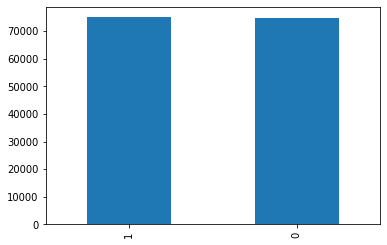

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


In [13]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


In [14]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


In [15]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [16]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [17]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [18]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [19]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [20]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [21]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


긍정 리뷰의 평균 길이 : 13.587751456414221
부정 리뷰의 평균 길이 : 17.029512266744973


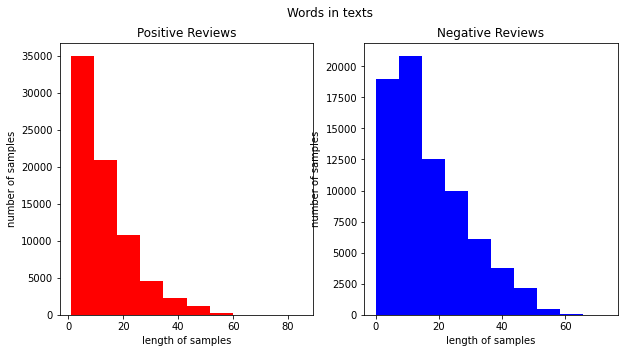

In [22]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [23]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [25]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39998
등장 빈도가 1번 이하인 희귀 단어의 수: 18213
단어 집합에서 희귀 단어의 비율: 45.53477673883694
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935688376196857


In [26]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21787


In [27]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [28]:
print(X_train[:3])

[[67, 2060, 299, 14259, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]


In [29]:
print(X_test[:3])

[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307541469075774


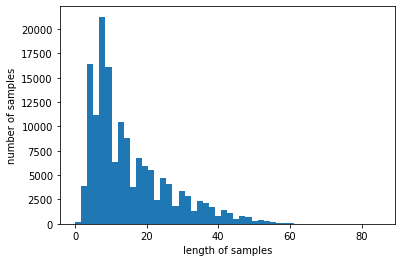

In [30]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [32]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [33]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [34]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.2708 - acc: 0.8977
Epoch 1: val_acc improved from -inf to 0.89179, saving model to best_model.h5
1875/1875 [==============================] - 53s 24ms/step - loss: 0.2708 - acc: 0.8977 - val_loss: 0.2937 - val_acc: 0.8918
Epoch 2/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.2146 - acc: 0.9225
Epoch 2: val_acc improved from 0.89179 to 0.92450, saving model to best_model.h5
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2147 - acc: 0.9225 - val_loss: 0.2093 - val_acc: 0.9245
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1983 - acc: 0.9294
Epoch 3: val_acc improved from 0.92450 to 0.92730, saving model to best_model.h5
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1983 - acc: 0.9294 - val_loss: 0.2041 - val_acc: 0.9273
Epoch 4/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.1873 - acc: 0.9331
Epoch 4: val_

In [35]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 14s 9ms/step - loss: 0.2109 - acc: 0.9258

 테스트 정확도: 0.9258


In [48]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = mecab.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len)

    score = float(loaded_model.predict(pad_new))
    if(score > 0.5):
        result_text = "{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100)
        print(result_text)
        return result_text

    else:
        result_text = "{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100)
        print(result_text)
        return result_text

In [49]:
a = sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')
type(a)

94.73% 확률로 긍정 리뷰입니다.


str

In [38]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

99.56% 확률로 부정 리뷰입니다.


In [45]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

96.37% 확률로 긍정 리뷰입니다.


In [52]:
if '긍정' in sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼'):
    print(1)
else:
    print(0)

96.37% 확률로 긍정 리뷰입니다.
1


In [40]:
sentiment_predict('빠르고 친절하게 설치까지 해죠서 좋습니다.')

96.29% 확률로 긍정 리뷰입니다.


In [83]:
df = pd.read_csv('/content/drive/MyDrive/리뷰마이닝/reviews_맞춤법 수정.csv')
df

,date,review,rate
0,2022-02-24 00:00:00,선물로 줬는데 사용해보니 정말 만족스럽다고 하네요.,1
1,2022-02-24 00:00:00,추천합니다,1
2,2022-02-22 00:00:00,배송도 빠르고,1
3,2022-02-22 00:00:00,기사님도 친절하셨어요.,1
4,2022-02-22 00:00:00,디자인 너무너무 맘에 들고요.,1
...,...,...,...
1426,2022-01-18 00:00:00,디자인도 공기청정기 중 가장 이쁜 거 같아요,1
1427,2022-01-18 00:00:00,디자인이 너무 예뻐요,1
1428,2022-01-18 00:00:00,선물시켰는데 받는 이가 좋아하네요,1
1429,2022-01-17 00:00:00,배송이 늦었지만,-1


In [84]:
df.dropna(inplace=True)

In [85]:
df

,date,review,rate
0,2022-02-24 00:00:00,선물로 줬는데 사용해보니 정말 만족스럽다고 하네요.,1
1,2022-02-24 00:00:00,추천합니다,1
2,2022-02-22 00:00:00,배송도 빠르고,1
3,2022-02-22 00:00:00,기사님도 친절하셨어요.,1
4,2022-02-22 00:00:00,디자인 너무너무 맘에 들고요.,1
...,...,...,...
1426,2022-01-18 00:00:00,디자인도 공기청정기 중 가장 이쁜 거 같아요,1
1427,2022-01-18 00:00:00,디자인이 너무 예뻐요,1
1428,2022-01-18 00:00:00,선물시켰는데 받는 이가 좋아하네요,1
1429,2022-01-17 00:00:00,배송이 늦었지만,-1


In [86]:
df['review'][0]

'선물로 줬는데 사용해보니 정말 만족스럽다고 하네요.'

In [87]:
df['new_rate'] = 0

In [88]:
df

,date,review,rate,new_rate
0,2022-02-24 00:00:00,선물로 줬는데 사용해보니 정말 만족스럽다고 하네요.,1,0
1,2022-02-24 00:00:00,추천합니다,1,0
2,2022-02-22 00:00:00,배송도 빠르고,1,0
3,2022-02-22 00:00:00,기사님도 친절하셨어요.,1,0
4,2022-02-22 00:00:00,디자인 너무너무 맘에 들고요.,1,0
...,...,...,...,...
1426,2022-01-18 00:00:00,디자인도 공기청정기 중 가장 이쁜 거 같아요,1,0
1427,2022-01-18 00:00:00,디자인이 너무 예뻐요,1,0
1428,2022-01-18 00:00:00,선물시켰는데 받는 이가 좋아하네요,1,0
1429,2022-01-17 00:00:00,배송이 늦었지만,-1,0


In [89]:
for i in range(0, len(df)):
    if '긍정' in sentiment_predict(df['review'][i]):
        df['new_rate'] = 1
    elif '부정' in sentiment_predict(df['review'][i]):
        pass

98.57% 확률로 긍정 리뷰입니다.
65.89% 확률로 긍정 리뷰입니다.
59.84% 확률로 긍정 리뷰입니다.
94.10% 확률로 긍정 리뷰입니다.
97.61% 확률로 긍정 리뷰입니다.
65.53% 확률로 긍정 리뷰입니다.
78.07% 확률로 부정 리뷰입니다.
78.07% 확률로 부정 리뷰입니다.
93.63% 확률로 부정 리뷰입니다.
93.63% 확률로 부정 리뷰입니다.
91.28% 확률로 긍정 리뷰입니다.
51.28% 확률로 부정 리뷰입니다.
51.28% 확률로 부정 리뷰입니다.
85.96% 확률로 부정 리뷰입니다.
85.96% 확률로 부정 리뷰입니다.
64.83% 확률로 부정 리뷰입니다.
64.83% 확률로 부정 리뷰입니다.
66.97% 확률로 긍정 리뷰입니다.
61.08% 확률로 부정 리뷰입니다.
61.08% 확률로 부정 리뷰입니다.
52.55% 확률로 부정 리뷰입니다.
52.55% 확률로 부정 리뷰입니다.
50.65% 확률로 부정 리뷰입니다.
50.65% 확률로 부정 리뷰입니다.
96.52% 확률로 긍정 리뷰입니다.
95.52% 확률로 긍정 리뷰입니다.
66.53% 확률로 부정 리뷰입니다.
66.53% 확률로 부정 리뷰입니다.
91.09% 확률로 긍정 리뷰입니다.
74.48% 확률로 긍정 리뷰입니다.
65.56% 확률로 긍정 리뷰입니다.
70.89% 확률로 긍정 리뷰입니다.
58.01% 확률로 긍정 리뷰입니다.
83.87% 확률로 긍정 리뷰입니다.
55.90% 확률로 부정 리뷰입니다.
55.90% 확률로 부정 리뷰입니다.
85.66% 확률로 긍정 리뷰입니다.
87.96% 확률로 긍정 리뷰입니다.
61.67% 확률로 긍정 리뷰입니다.
85.97% 확률로 긍정 리뷰입니다.
78.69% 확률로 긍정 리뷰입니다.
67.24% 확률로 긍정 리뷰입니다.
54.48% 확률로 부정 리뷰입니다.
54.48% 확률로 부정 리뷰입니다.
97.98% 확률로 부정 리뷰입니다.
97.98% 확률로 부정 리뷰입니다.
96.02% 확률로 긍정 리뷰입니다.
74.31% 확률로 부정

In [90]:
df

,date,review,rate,new_rate
0,2022-02-24 00:00:00,선물로 줬는데 사용해보니 정말 만족스럽다고 하네요.,1,1
1,2022-02-24 00:00:00,추천합니다,1,1
2,2022-02-22 00:00:00,배송도 빠르고,1,1
3,2022-02-22 00:00:00,기사님도 친절하셨어요.,1,1
4,2022-02-22 00:00:00,디자인 너무너무 맘에 들고요.,1,1
...,...,...,...,...
1426,2022-01-18 00:00:00,디자인도 공기청정기 중 가장 이쁜 거 같아요,1,1
1427,2022-01-18 00:00:00,디자인이 너무 예뻐요,1,1
1428,2022-01-18 00:00:00,선물시켰는데 받는 이가 좋아하네요,1,1
1429,2022-01-17 00:00:00,배송이 늦었지만,-1,1


In [92]:
df['rate'].dtype

dtype('int64')

In [93]:
df['new_rate'].dtype

dtype('int64')

In [94]:
len(df)

1431

In [96]:
(df['rate'] == df['new_rate']).value_counts()

True     1174
False     257
dtype: int64

In [97]:
1174/1431

0.8204053109713487

In [53]:
df = pd.read_csv('/content/drive/MyDrive/리뷰마이닝/reviews.csv')

In [56]:
from konlpy.tag import Okt

In [57]:
okt = Okt()

In [59]:
for i in range(0, len(df)):
    print(okt.nouns(df['review'][i]))

[]
[]
[]
['배송', '곳']
['배송']
['청소기', '색상', '구매']
[]
['살균', '기능', '는걸', '구매']
['공기']
['배송']
['기사']
['매우', '만족']
['선물', '사용', '정말', '추천']
['디자인', '소음', '거의']
['배송']
['공간', '차지']
['디자인', '맘에듭니', '안방', '주방']
['디자인']
['디자인']
['디자인']
['배송']
['공기청정기', '소음']
[]
['배송', '기사', '디자인', '맘', '엘지']
['어머니', '집', '사']
['배송']
['기존', '공기청정기', '사용', '중', '기사', '말', '제품', '대비', '에어로', '타워', '공기', '청정', '면적', '생각']
['크기', '커서', '처음', '고민']
['집안', '큐', '처음', '온', '모드']
['큐', '온', '모드', '희망', '온도', '설정', '온', '모드', '자동', '등', '설정', '수가']
['큐', '때', '공기청정기', '선택', '해당', '목록', '밑', '공기청정기', '팬', '나오니', '그거', '선택', '연결']
['온', '모드', '해', '잠시', '시간', '열기', '공기', '청정도']
['공기', '청정', '면적']
['이동', '때', '이동']
['공기청정기', '무빙', '받침', '거', '말']
['겨울', '앞', '더', '이용', '보고', '여름', '에어컨', '순환', '용', '기대']
['배송', '일주일', '정도']
['생각', '무거워']
['조작', '방법']
['사계절', '수', '장점', '온', '가동', '해', '생각', '느낌']
['전', '아침', '때', '등', '냉기', '때', '효과', '것']
['기세', '부담', '만큼', '것']
['제', '활동', '반경', '주로', '거실', '주로', '침실', '사용', '거']
['티비', '

AssertionError: ignored